In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.cm as cm

from sklearn.metrics import silhouette_samples, silhouette_score
from wordcloud import WordCloud
from sklearn.cluster import KMeans

In [2]:
def load_data(filename):
    """
    Loads given file as pandas dataframe.
    
    Argument:
        filename: string, name of file
        
    Return:
        pandas dataframe
    """
    return pd.read_csv(filename)

In [3]:
data = load_data("./Songs_features/songs_all.csv")

In [4]:
data.head(5)

,file,pid,track_name,artist_name,duration_ms,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,popularity,release_day
0,0,0,"[""Lose Control (feat. Ciara & Fat Man Scoop) T...","[""Missy Elliott Britney Spears Beyoncé Justin ...",221777.192308,0.659288,0.782173,5.038462,-4.881942,0.692308,0.083440,0.000676,0.192127,0.642904,123.006885,49.557692,5107.711538
1,0,1,"[""Eye of the Tiger Libera Me From Hell (Tengen...","[""Survivor Daniel Tidwell Daniel Tidwell Danie...",298883.846154,0.496459,0.691077,4.461538,-8.291667,0.538462,0.163100,0.222270,0.178433,0.476667,122.669615,49.128205,10323.384615
2,0,2,"[""Like You GOOD (feat. ELO) Inferiority Comple...",['Hoody Loco Park Kyung Park Kyung BTS Lovelyz...,219374.343750,0.671875,0.693203,5.000000,-4.874156,0.515625,0.269230,0.000638,0.169028,0.565078,114.600672,45.203125,1333.500000
3,0,3,"[""Danse macabre Piano concerto No. 2 in G Mino...",['Camille Saint-Saëns Camille Saint-Saëns No V...,229571.888889,0.513714,0.621282,5.103175,-9.614937,0.714286,0.273870,0.202042,0.188585,0.451623,125.032413,29.500000,4629.261905
4,0,4,"['Tonight, Tonight Wonderwall - Remastered I D...",['The Smashing Pumpkins Oasis Aerosmith Natali...,255016.588235,0.576765,0.650535,3.352941,-7.634471,0.823529,0.177148,0.081875,0.166524,0.490765,127.759882,47.176471,8413.823529


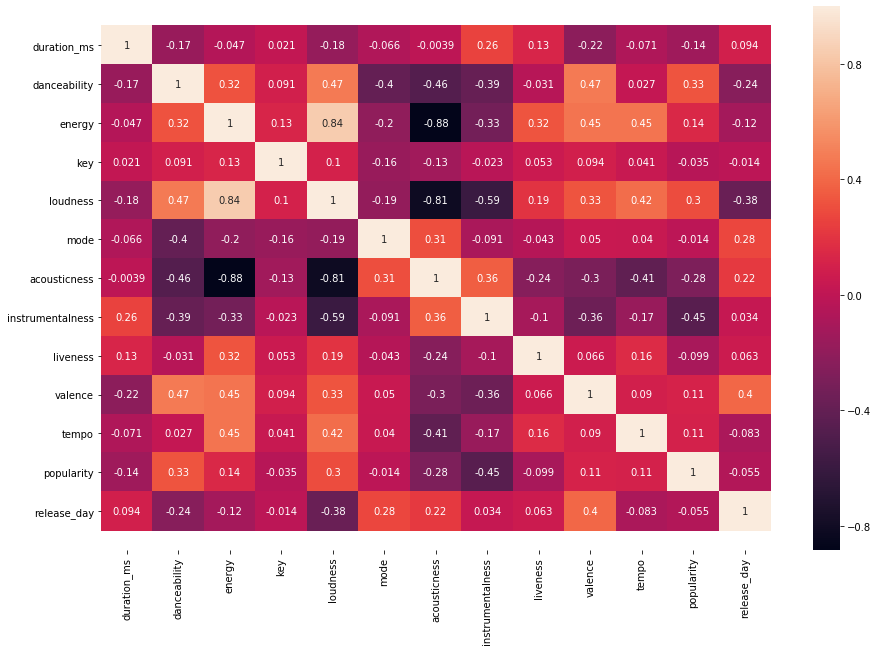

In [5]:
# calculate the correlation matrix
cols = data.columns[2:]
corr = data.loc[:,cols].corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig("figures/correlation_matrix.png") 

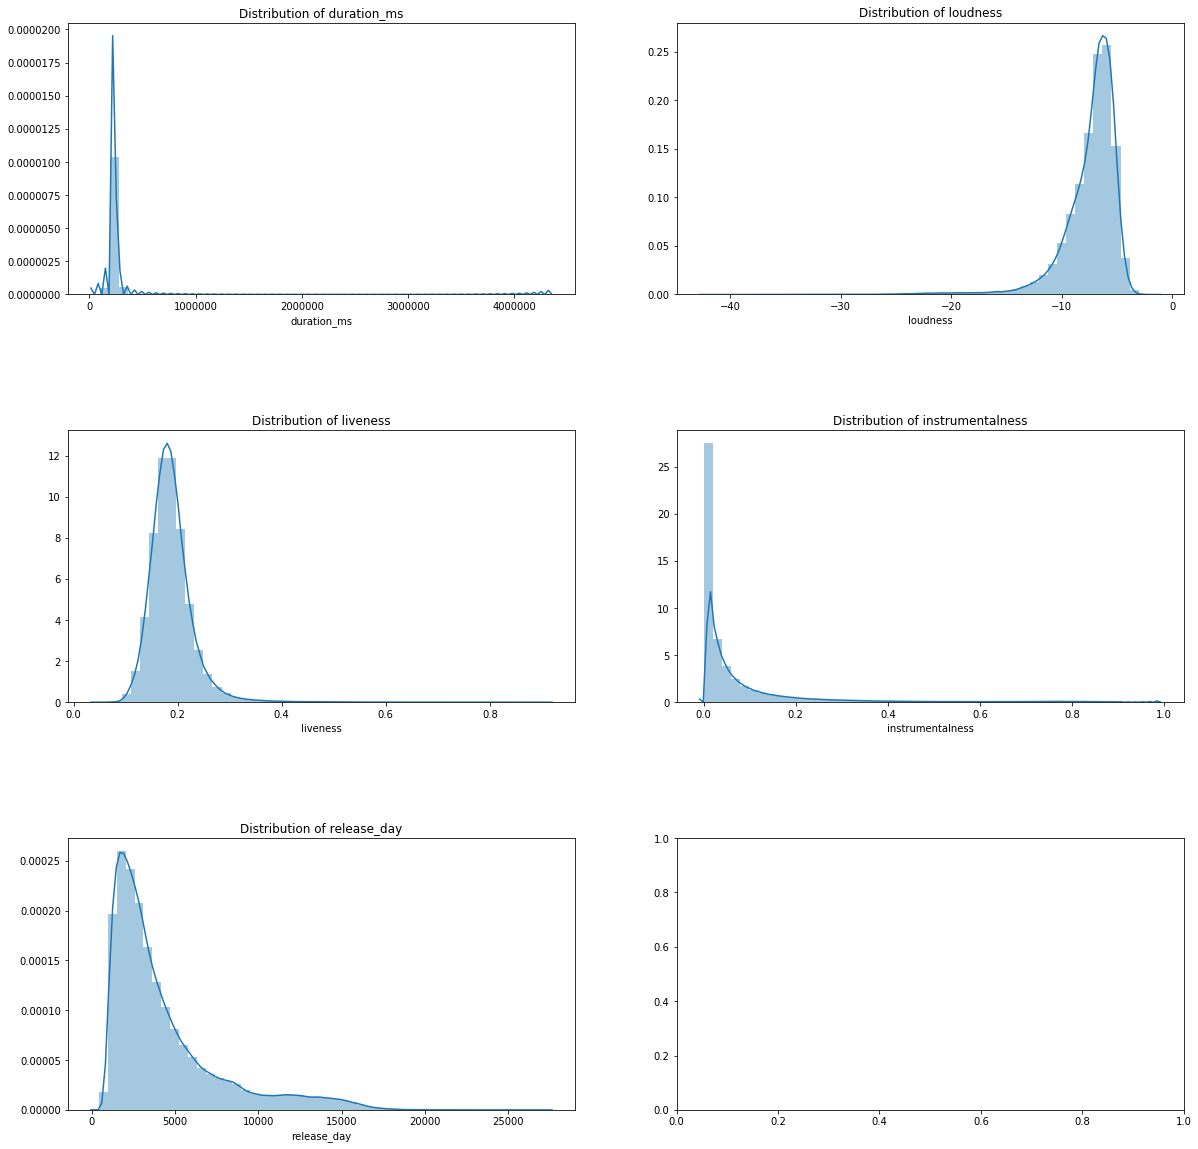

In [6]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
fig.subplots_adjust(hspace=.5)

i, j = 0, 0
cols = ['duration_ms', 'loudness', 'liveness', 'instrumentalness', 'release_day']
#cols = data.columns[~data.columns.isin(cols)]
#cols = cols[3:]

# seaborn distribution plot
for c in cols:

    sns.distplot(data[c].values, ax=ax[i, j])
    ax[i, j].set_xlabel(c)
    ax[i, j].set_title("Distribution of " + c)
    
    j += 1
    
    if j == 2:
        i += 1
        j = 0
    
    # save plots to img folder
    #fname = "img/distplot/" + str(column) + "_distplot.png"
plt.savefig("figures/distribution_1.png")

In [7]:
cols = data.columns[4:]
df = data[cols].values

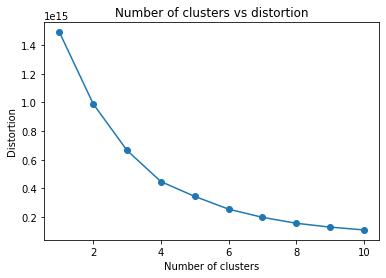

In [8]:
# Elbow method
distortions = []

for i in range(1,11):
    clusterer = KMeans(n_clusters=i, random_state=0)
    clusterer.fit(df)
    cluster_labels = clusterer.fit_predict(df)
    distortions.append(clusterer.inertia_)
    
plt.plot(range(1,11),distortions,marker='o')
plt.title("Number of clusters vs distortion")
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.savefig("figures/elbow_method.png")

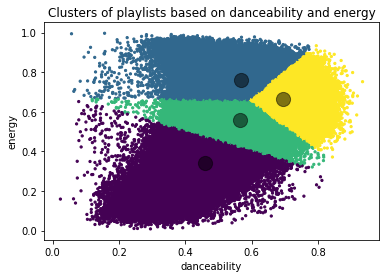

In [9]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[:, [1, 2]])
y_kmeans = kmeans.predict(df[:, [1, 2]])


#scatter our data with colors
plt.scatter(df[:, 1], 
            df[:, 2], 
            c=y_kmeans, s=5, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.xlabel("danceability")
plt.ylabel("energy")
plt.title("Clusters of playlists based on danceability and energy")
plt.savefig("figures/kmeans_clusters.png")

In [10]:
data["k_means_label"] = y_kmeans

In [11]:
df = data.groupby("k_means_label").agg({"artist_name" : lambda x: ' '.join(x)})

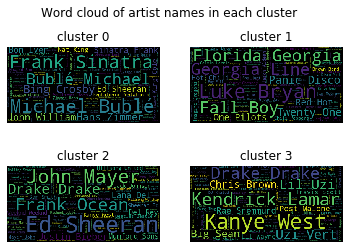

In [12]:
fig, ax = plt.subplots(2, 2)
j, k = 0, 0

for i in range(len(df)):

    wc = WordCloud().generate(df.iloc[i]["artist_name"])
    ax[j, k].imshow(wc)
    ax[j, k].axis("off")
    ax[j, k].set_title("cluster " + str(i))
    
    k += 1
    if k == 2:
        k = 0
        j += 1
        
fig.suptitle("Word cloud of artist names in each cluster")
plt.savefig("figures/word_cloud.png")